In [14]:
import pickle, os
import numpy as np 

data = None
with open('train_data.pickle', 'rb') as f:
    data = pickle.load(f)

x_train = data['x']
y_train = data['y']
print(x_train.shape)
print(y_train.shape)

data = None
with open('test_data.pickle', 'rb') as f:
    data = pickle.load(f)

x_test = data['x']
y_test = data['y']
print(x_test.shape)
print(y_test.shape)

(1604195, 10, 24)
(1604195,)
(1595290, 10, 24)
(1595290,)


In [15]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Reshape, Dense, Lambda, Dropout, Activation, \
        TimeDistributed, Convolution1D, Convolution2D, Concatenate, LSTM, MaxPooling1D, AveragePooling1D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

2023-05-10 00:20:27.286408: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):

    epochs = range(1, len(train_loss)+1)
    plt.plot(epochs, train_loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'y', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

def plot_accuracy(train_acc, val_acc):

    epochs = range(1, len(train_acc)+1)
    plt.plot(epochs, train_acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'y', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

def plot_history(history):
    
    history_dict = history.history
    history_dict.keys()
    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plot_loss(train_loss, val_loss)
    plt.subplot(1,2,2)
    plot_accuracy(train_acc, val_acc)
    plt.show()

In [17]:
SEED = 513
FILTER_SIZE = (1, 2)
STRIDE = (1, 2)
FILTER_COUNT = 64
BATCH_SIZE = 32
NUM_EPOCH = 20

CLASSES = ['sell', 'neutral', 'buy']

def train_lstm(x, y, model_path):
    
    y = to_categorical(y, len(CLASSES))
    (x_train, x_val, y_train, y_val) = train_test_split(x, y, test_size=0.1,
            random_state=SEED)

    print('Building model...')
    print(x_train.shape)
    print(y_train.shape)
    
    model = Sequential()
    model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(len(CLASSES), activation='softmax'))

    opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    model.summary()

    print('Training...')
    history = model.fit(
        x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH,
        validation_data=(x_val, y_val), verbose=1, callbacks=[
            ModelCheckpoint(
                model_path + "best_lstm_model.h5", save_best_only=True, monitor='val_loss', verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            ),
            ]
    )
    
    from datetime import datetime
    import time
    
    timestamp = time.time()
    date_time = datetime.fromtimestamp(timestamp)
    date_time = date_time.strftime("%Y-%m-%d--%H-%M-%S-")
    model_name = date_time + "model.h5" 
    
    model.save(model_path + model_name)

    plot_history(history)

    return model

In [18]:
SEED = 513
FILTER_SIZE = (1, 2)
STRIDE = (1, 2)
FILTER_COUNT = 32
BATCH_SIZE = 32
NUM_EPOCH = 40

CLASSES = ['sell', 'neutral', 'buy']

def train_cnn(x, y, model_path):
    
    y = to_categorical(y, len(CLASSES))
    (x_train, x_val, y_train, y_val) = train_test_split(x, y, test_size=0.1,
            random_state=SEED)

    print('Building model...')
    print(x_train.shape)
    print(y_train.shape)
    
    x_train = np.expand_dims(x_train, -1)
    x_val = np.expand_dims(x_val, -1)
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])

    model_input = Input(input_shape, name='input')
    layer = model_input
    
    layer = Convolution2D(filters=FILTER_COUNT,
                          kernel_size=FILTER_SIZE,
                          strides=STRIDE,
                          padding='same',
                          name='convolution_' + '1'
                          )(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)

    layer = Convolution2D(filters=FILTER_COUNT,
                          kernel_size=FILTER_SIZE,
                          strides=STRIDE,
                          padding='same',
                          name='convolution_' + '2'
                          )(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)

    layer = Convolution2D(filters=FILTER_COUNT,
                          kernel_size=(1, 6),
                          strides=(1, 6),
                          padding='same',
                          name='convolution_' + '3'
                          )(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    
    layer = Reshape((layer.shape[1], -1))(layer)
    print(layer.shape)
    
    layer = LSTM(64)(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(len(CLASSES), name='output_layer')(layer)
    layer = Activation('softmax')(layer)

    model_output = layer
    model = Model(model_input, model_output)
    opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

    model.summary()

    print('Training...')
    history = model.fit(
        x_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCH,
        validation_data=(x_val, y_val), verbose=1, callbacks=[
            ModelCheckpoint(
                model_path + "best_cnn_model.h5", save_best_only=True, monitor='val_loss', verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            ),
            ]
    )
    
    from datetime import datetime
    import time
    
    timestamp = time.time()
    date_time = datetime.fromtimestamp(timestamp)
    date_time = date_time.strftime("%Y-%m-%d--%H-%M-%S-")
    model_name = date_time + "model.h5" 
    
    model.save(model_path + model_name)

    plot_history(history)

    return model

In [19]:
model = train_cnn(x_train, y_train, 'models/')

KeyboardInterrupt: 

In [74]:
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
import os 

def load_saved_model(model_name, x_test, y_test):
    model = load_model("models/" + model_name)
    model.summary()
    return model
    
trained_model = load_saved_model("best_cnn_model.h5", x_test, y_test)

2023-05-09 21:24:16.435219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 21:24:16.438299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 21:24:16.441856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 10, 24, 1)]       0         
                                                                 
 convolution_1 (Conv2D)      (None, 10, 12, 32)        96        
                                                                 
 activation (Activation)     (None, 10, 12, 32)        0         
                                                                 
 dropout (Dropout)           (None, 10, 12, 32)        0         
                                                                 
 convolution_2 (Conv2D)      (None, 10, 6, 32)         2080      
                                                                 
 activation_1 (Activation)   (None, 10, 6, 32)         0         
                                                                 
 dropout_1 (Dropout)         (None, 10, 6, 32)         0     

[0. 1. 2.]


2023-05-09 21:24:34.394960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-09 21:24:34.400961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-09 21:24:34.403791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

49853/49853 [==============================] - 154s 3ms/step
[[      8  131036    8260]
 [      2 1273772   58605]
 [      0   26563   97044]]
accuracy: 0.8592945483266365
f1_score: 0.8221734461641753


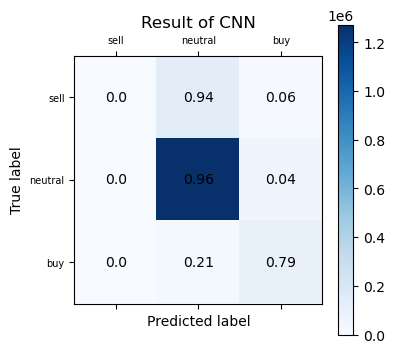

139304
1332379
123607


In [75]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

CLASSES = ['sell', 'neutral', 'buy']

def plot_confusion_matrix(conf_matrix):
    conf_matrix_percentage = np.zeros(shape=(len(CLASSES), len(CLASSES)))
    for i in range(len(CLASSES)):
        for j in range(len(CLASSES)):
            conf_matrix_percentage[i][j] = conf_matrix[i][j] / np.sum(conf_matrix[i,:])
    conf_matrix_percentage = np.transpose(np.round(conf_matrix_percentage, 2))
    plt.figure(figsize=(4, 4))
    plt.matshow(conf_matrix, fignum=1, cmap=plt.cm.Blues)
    plt.colorbar()
    for x in range(len(conf_matrix_percentage)):
        for y in range(len(conf_matrix_percentage)):
            plt.annotate(conf_matrix_percentage[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center') 
    plt.title('Result of CNN')    
    plt.xticks(range(len(CLASSES)),CLASSES[:len(CLASSES)],color='black',fontsize=7)
    plt.yticks(range(len(CLASSES)),CLASSES[:len(CLASSES)],color='black',fontsize=7)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()     


def model_predict(model, x_test, y_test):
    y_test = to_categorical(y_test, len(CLASSES))
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    assert len(y_pred) == len(y_true)
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    plot_confusion_matrix(conf_matrix)
    return y_pred
    
y_pred = model_predict(trained_model, x_test, y_test)

In [90]:
from sklearn.metrics import precision_score, recall_score

y_true = np.argmax(to_categorical(y_test, len(CLASSES)), axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
score = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print("f1_score: {}".format(score))
print("accuracy: {}".format(accuracy))
print("precision: {}".format(precision))
print("recall: {}".format(recall))
recall_for_sells = conf_matrix[0][0] / np.sum(conf_matrix[0, :])
recall_for_buys = conf_matrix[2][2] / np.sum(conf_matrix[2, :])
precision_for_sells = conf_matrix[0][0] / np.sum(conf_matrix[:, 0])
precision_for_buys = conf_matrix[2][2] / np.sum(conf_matrix[:, 2])
print("recall_for_sells: {}".format(recall_for_sells))
print("recall_for_buys: {}".format(recall_for_buys))
print("precision_for_sells: {}".format(precision_for_sells))
print("precision_for_buys: {}".format(precision_for_buys))

[[      8  131036    8260]
 [      2 1273772   58605]
 [      0   26563   97044]]
f1_score: 0.5323122528375327
accuracy: 0.8592945483266365
precision: 0.7606522328098024
recall: 0.5803906207544101
recall_for_sells: 5.742835812324125e-05
recall_for_buys: 0.7851011674096128
precision_for_sells: 0.8
precision_for_buys: 0.5920602285414468
